In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def show_img(img):
    img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [20]:
ori_files = sorted(glob('./stage2_data/stage2_rectification/input_imgs/*'))
warped_files = sorted(glob('./stage2_data/stage2_rectification/warped_imgs/*'))

ori_img = cv2.imread(ori_files[9],1)
warped_img = cv2.imread(warped_files[9],1)
ori_img_gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
warped_img_gray = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)

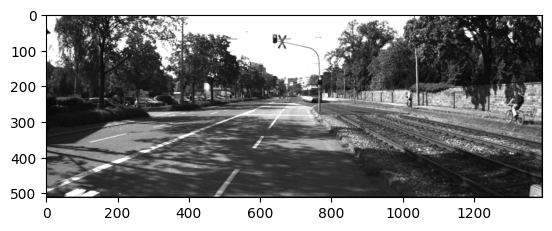

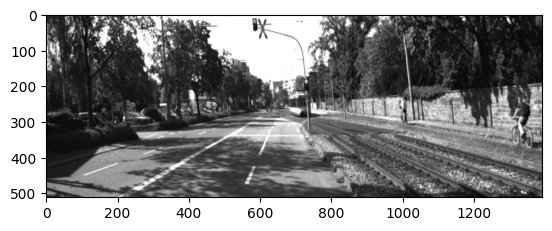

(None, None)

In [21]:
show_img(ori_img_gray),show_img(warped_img_gray)

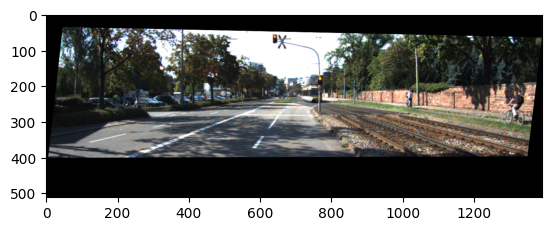

In [22]:
sift = cv2.SIFT_create()

# SIFT to describe features
keypoint_warped, descriptor_warped = sift.detectAndCompute(warped_img_gray, None)
keypoint_ori, descriptor_ori = sift.detectAndCompute(ori_img_gray, None)

# Match the features
bf = cv2.BFMatcher()
matches = bf.match(descriptor_warped, descriptor_ori)

# Find the best match with smallest distance
matches = sorted(matches, key = lambda x:x.distance)

# Extract the matches
points_warped = np.zeros((len(matches), 2))
points_ori = np.zeros((len(matches), 2))

for idx, match in enumerate(matches):
    points_warped[idx, :] = keypoint_warped[match.queryIdx].pt
    points_ori[idx, :] = keypoint_ori[match.trainIdx].pt

# Find a good homography
H, mask = cv2.findHomography(points_warped, points_ori, cv2.RANSAC)
imgRectified = cv2.warpPerspective(warped_img, H, (warped_img.shape[1] , warped_img.shape[0]))

show_img(imgRectified)

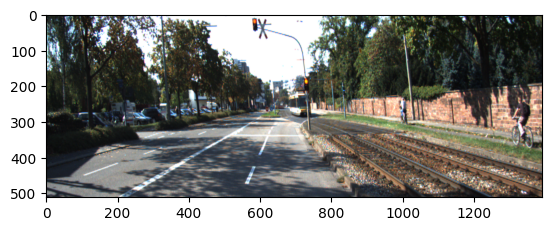

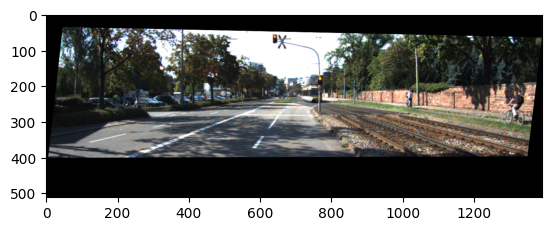

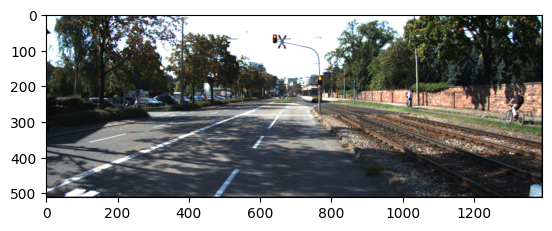

(None, None, None)

In [23]:
show_img(warped_img), show_img(imgRectified), show_img(ori_img)

In [11]:
import largestinteriorrectangle as lir

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def psnr_ssim_rect(orig_img, rectified_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(rectified_img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image (black and white)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    grid = thresh.astype(np.bool_)

    rectangle = lir.lir(grid)
    
    (x_min, y_min) = lir.pt1(rectangle)
    (x_max, y_max) = lir.pt2(rectangle)

    # Crop the image using the inscribed rectangle's coordinates
    cropped_img = orig_img[y_min:y_max, x_min:x_max]
    cropped_img_rect = rectified_img[y_min:y_max, x_min:x_max]

    
    psnr_out = psnr(cropped_img, cropped_img_rect)
    ssim_out = ssim(cropped_img, cropped_img_rect, channel_axis=-1)

    return (psnr_out, ssim_out)

In [7]:
psnr_ssim_rect(ori_img, imgRectified)

(33.77303605399928, 0.9693910735774542)

In [8]:
def unwarp_img(ori_img,warped_img):
    ori_img_gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
    warped_img_gray = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()

    # Use SIFT to describe features
    keypoint_warped, descriptor_warped = sift.detectAndCompute(warped_img_gray, None)
    keypoint_ori, descriptor_ori = sift.detectAndCompute(ori_img_gray, None)

    # Match the features
    bf = cv2.BFMatcher()
    matches = bf.match(descriptor_warped, descriptor_ori)

    # Find and extract the best match with smallest distance
    matches = sorted(matches, key = lambda x:x.distance)
    points_warped = np.zeros((len(matches), 2))
    points_ori = np.zeros((len(matches), 2))
    for idx, match in enumerate(matches):
        points_warped[idx, :] = keypoint_warped[match.queryIdx].pt
        points_ori[idx, :] = keypoint_ori[match.trainIdx].pt

    # Find a good homography using RANSAC
    H, mask = cv2.findHomography(points_warped, points_ori, cv2.RANSAC)
    imgRectified = cv2.warpPerspective(warped_img, H, (warped_img.shape[1] , warped_img.shape[0]))
    return imgRectified

In [9]:
result_list = list()
for i,j in zip(ori_files, warped_files):
    ori_img = cv2.imread(i,1)
    warped_img = cv2.imread(j,1)
    result_list.append(psnr_ssim_rect(ori_img, unwarp_img(ori_img,warped_img)))

In [10]:
cal_avg = lambda x: (np.mean([i[0] for i in x]), np.mean([i[1] for i in x]))
avg_PSNR, avg_SSIM = cal_avg(result_list)
print(f'Average PSNR across {len(ori_files)} images:', avg_PSNR)
print(f'Average SSIM across {len(ori_files)} images:', avg_SSIM)

Average PSNR across 11 images: 31.425065407042688
Average SSIM across 11 images: 0.9123614893676752
